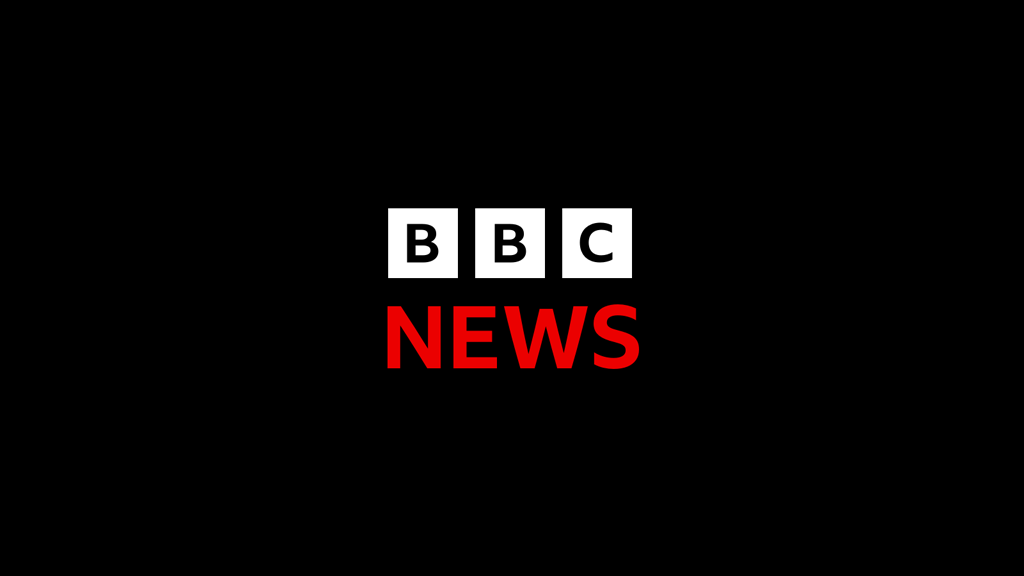

## Building a system that can accurately classify previously unseen news articles into the right category

---

## Summary 

1. [Load the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Classification with Count Vectorizer](#3)
4. [Classification with TF-IDF](#4)
5. [Classification with CNNs and Embeddings](#5)

---

<a id="1"></a>
# 1. Load the Data 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  
from collections import Counter

import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import wordnet,stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

from xgboost import XGBClassifier

import tensorflow as tf

from warnings import simplefilter
simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

/kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
/kaggle/input/bbc-articles-dataset/archive (2)/bbc-news-data.csv
/kaggle/input/bbc-articles-dataset/archive/bbc_text_cls.csv


In [2]:
pd.set_option('display.max_colwidth',None)
df = pd.read_csv('/kaggle/input/bbc-articles-dataset/archive/bbc_text_cls.csv')

df.head(2)

,text,labels
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.",business
1,"Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""\n\nWorries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent comments in a maj

One can notice that the text content is quite large and also that it may need a bit of pre-processing.

I am performing a train-test splitting to get a train and a test dataset.

In [3]:
inputs = df['text']
labels = df['labels']

X_train,X_test,y_train,y_test = train_test_split(inputs,labels,random_state=42)

Then, I am printing the shapes of the train and test data.

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1668,), (557,), (1668,), (557,))

One can notice that the input data is split in 25%-75% fractions. Also that the *X* train and test matrices are 1D (or single-column) vectors.

I also need to check whether there are null and/or duplicate values in the test ...

In [5]:
print(f'Null values in X_test: {X_test.isna().sum()}; null values in y_test: {y_test.isna().sum()}\n')

print(f'Duplicate values in X_test: {X_test.duplicated().sum()}')

Null values in X_test: 0; null values in y_test: 0

Duplicate values in X_test: 5


... and in the train data.

In [6]:
print(f'Null values in X_train: {X_train.isna().sum()}; null values in y_train: {y_train.isna().sum()}\n')

print(f'Duplicate values in X_train: {X_train.duplicated().sum()}')

Null values in X_train: 0; null values in y_train: 0

Duplicate values in X_train: 57


There are no missing values in the train and test datasets, but there are duplicate entries. Duplicates may have to be dropped to improve the accuracy of the predictions.

<a id="2"></a>
# 2. Exploratory Data Analysis

### 2.1 Target Classes

It is interesting to plot a histogram of the target classes. This is useful to know what they are and also to see whether the classes are balanced or not.

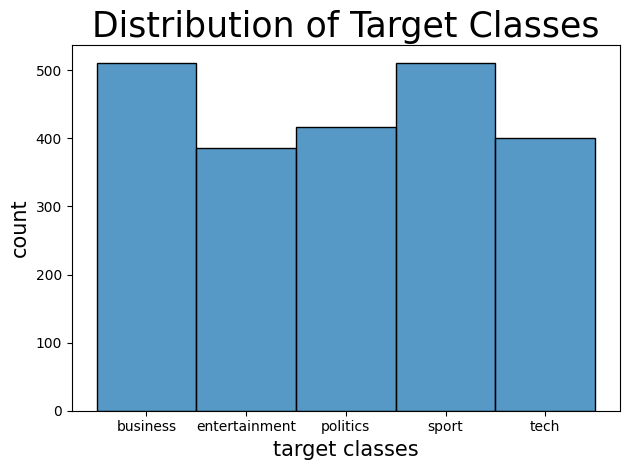

In [7]:
sns.histplot(data=labels)

plt.title('Distribution of Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

As shown in the plot, one can notice that:
* There are 5 target classes. They represent the main topics of the BBC articles.
* There is a relatively good balance between the classes. The maximum difference in count between them is of the order of 20%. This is why there is no need of using resampling techniques to get a closer balance between them.

## 2.2 Text

I want to check if the sport, business ... type articles differ by the word length, number of words, most frequent words, and so on.

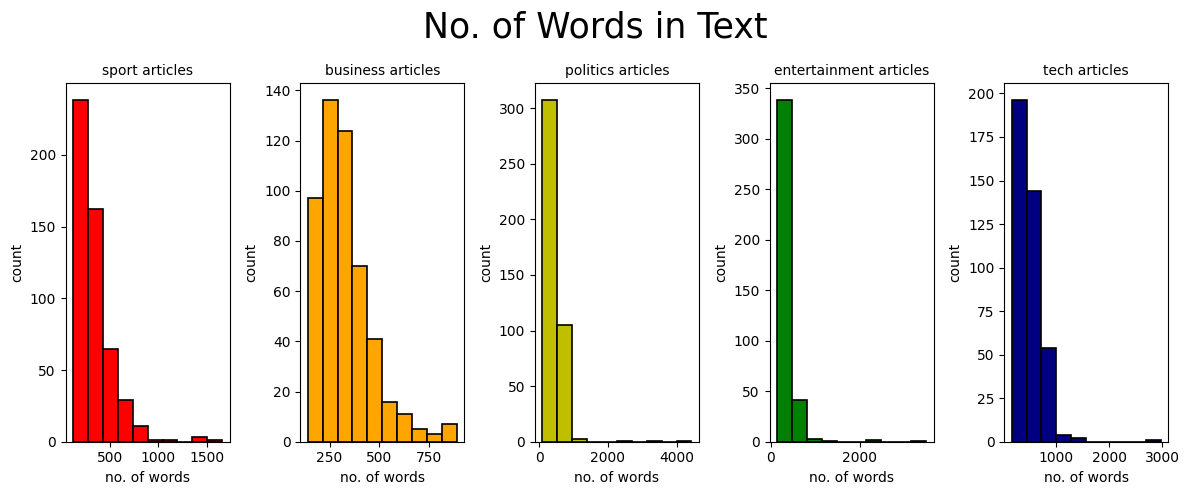

In [8]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5,figsize=(12,5))

wd_len_sp = df[df['labels']=='sport']['text'].str.split().map(lambda x: len(x))
ax1.hist(wd_len_sp,color='red',edgecolor='black',linewidth=1.2)
ax1.set_title('sport articles',size=10)
ax1.set_xlabel('no. of words',size=10)
ax1.set_ylabel('count',size=10)

wd_len_bus = df[df['labels']=='business']['text'].str.split().map(lambda x: len(x))
ax2.hist(wd_len_bus,color='orange',edgecolor='black',linewidth=1.2)
ax2.set_title('business articles',size=10)
ax2.set_xlabel('no. of words',size=10)
ax2.set_ylabel('count',size=10)

wd_len_pol = df[df['labels']=='politics']['text'].str.split().map(lambda x: len(x))
ax3.hist(wd_len_pol,color='y',edgecolor='black',linewidth=1.2)
ax3.set_title('politics articles',size=10)
ax3.set_xlabel('no. of words',size=10)
ax3.set_ylabel('count',size=10)

wd_len_ent = df[df['labels']=='entertainment']['text'].str.split().map(lambda x: len(x))
ax4.hist(wd_len_ent,color='g',edgecolor='black',linewidth=1.2)
ax4.set_title('entertainment articles',size=10)
ax4.set_xlabel('no. of words',size=10)
ax4.set_ylabel('count',size=10)

wd_len_te = df[df['labels']=='tech']['text'].str.split().map(lambda x: len(x))
ax5.hist(wd_len_te,color='navy',edgecolor='black',linewidth=1.2)
ax5.set_title('tech articles',size=10)
ax5.set_xlabel('no. of words',size=10)
ax5.set_ylabel('count',size=10)

plt.suptitle("No. of Words in Text",size=25)
plt.tight_layout()
plt.show()

Below I calculate the mean value of the above distibutions.

In [9]:
print(f'mean no. of words in sport articles: {wd_len_sp.mean():.1f}')
print(f'mean no. of words in business articles: {wd_len_bus.mean():.1f}')
print(f'mean no. of words in politics articles: {wd_len_pol.mean():.1f}')
print(f'mean no. of words in entertainment articles: {wd_len_ent.mean():.1f}')
print(f'mean no. of words in tech articles: {wd_len_te.mean():.1f}')

mean no. of words in sport articles: 329.3
mean no. of words in business articles: 328.9
mean no. of words in politics articles: 454.0
mean no. of words in entertainment articles: 330.6
mean no. of words in tech articles: 502.7


Then, I calculate the average word length in the 5 types of articles.

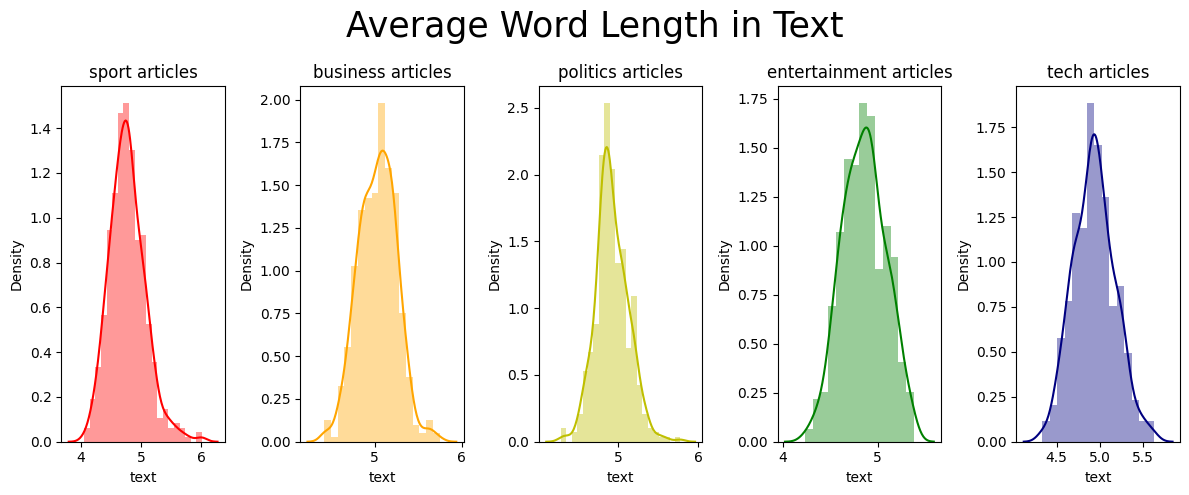

In [10]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5,figsize=(12,5))

char_len_sp = df[df['labels']=='sport']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_sp.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('sport articles',size=12)

char_len_bus = df[df['labels']=='business']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_bus.map(lambda x: np.mean(x)),ax=ax2,color='orange')
ax2.set_title('business articles',size=12)     

char_len_pol = df[df['labels']=='politics']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_pol.map(lambda x: np.mean(x)),ax=ax3,color='y')
ax3.set_title('politics articles',size=12) 

char_len_ent = df[df['labels']=='entertainment']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ent.map(lambda x: np.mean(x)),ax=ax4,color='g')
ax4.set_title('entertainment articles',size=12)

char_len_te = df[df['labels']=='tech']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_te.map(lambda x: np.mean(x)),ax=ax5,color='navy')
ax5.set_title('tech articles',size=12)

plt.suptitle("Average Word Length in Text",size=25)
plt.tight_layout()
plt.show()

The average word length for the different article types is similar (around 5 characters).

## 2.3 Most Frequent Words in the Target Classes

I am plotting the wordclouds with the most frequent words in the articles belonging to each target class.

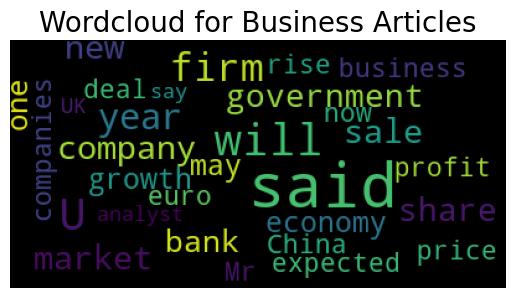

In [11]:
text = ' '.join(df[df['labels']=='business']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=30).generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for Business Articles",fontsize=20)
plt.show()

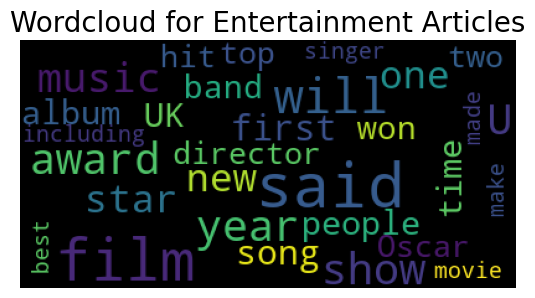

In [12]:
text = ' '.join(df[df['labels']=='entertainment']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=30).generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for Entertainment Articles",fontsize=20)
plt.show()

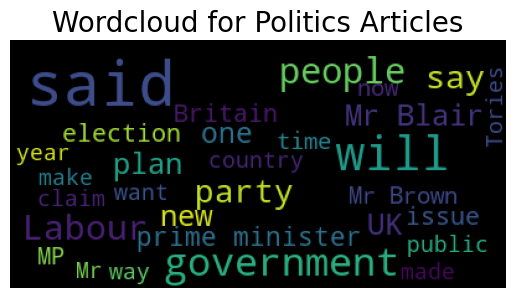

In [13]:
text = ' '.join(df[df['labels']=='politics']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=30).generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for Politics Articles",fontsize=20)
plt.show()

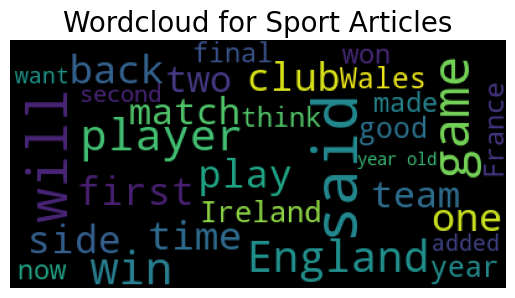

In [14]:
text = ' '.join(df[df['labels']=='sport']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=30).generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for Sport Articles",fontsize=20)
plt.show()

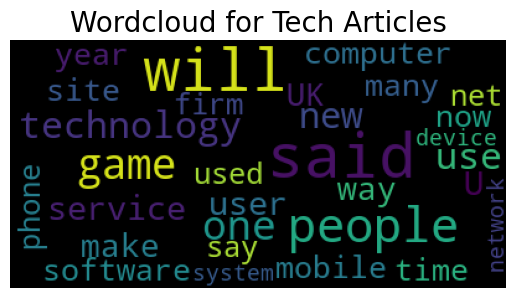

In [15]:
text = ' '.join(df[df['labels']=='tech']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=30).generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for Tech Articles",fontsize=20)
plt.show()

<a id="3"></a>
# 3. Classification with Count Vectorizer

## 3.1 First Set of Results

Count Vectorizer converts a collection of text documents to a matrix of token counts. See [*CountVectorizer*](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) on scikit-learn.org.

I can instantiate the CountVectorizer and apply it to *X_train* and *X_test*.

In [16]:
vectorizer = CountVectorizer()

X_train2 = vectorizer.fit_transform(X_train)
X_test2  = vectorizer.transform(X_test)

Finally, I can use a multinomial Naive Bayes classifier (MultinomialNB model) to classify the data. But before doing this, I am introducing a function to print a table with the model scores.

In [17]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table 

In [18]:
MNB = MultinomialNB()
MNB.fit(X_train2,y_train)

MNB_train_preds = MNB.predict(X_train2)

MNB_train_results = get_test_scores('MNBB (train)',MNB_train_preds,y_train)
MNB_train_results

,model,precision,recall,F1,accuracy
0,MNBB (train),0.994718,0.995162,0.99492,0.995204


In [19]:
MNB_test_preds = MNB.predict(X_test2)

MNB_test_results = get_test_scores('MNBB (test)',MNB_test_preds,y_test)
MNB_test_results

,model,precision,recall,F1,accuracy
0,MNBB (test),0.970711,0.972471,0.971398,0.971275


I am plotting the confusion matrix for the predictions on the test data.

In [20]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((unique, counts)).T)

[['business' 142]
 ['entertainment' 94]
 ['politics' 95]
 ['sport' 122]
 ['tech' 104]]


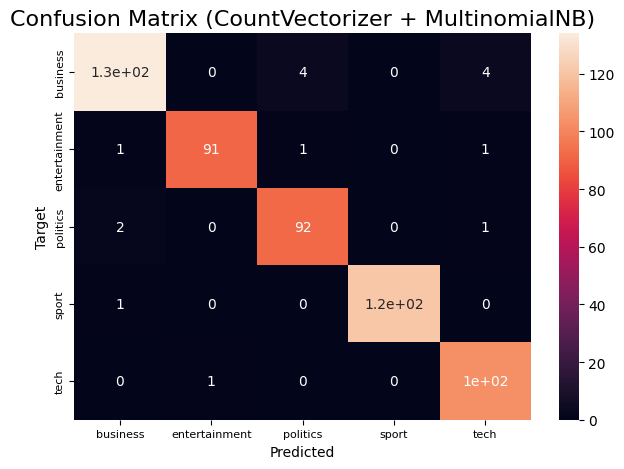

In [21]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,MNB_test_preds,labels=MNB.classes_)

ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (CountVectorizer + MultinomialNB)',fontsize=16)
ax.xaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.yaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

## 3.2 Second Set of Results

I am trying the same method, but this time I will try to deal with stop words.

In [22]:
vectorizer = CountVectorizer(stop_words='english',analyzer='word')

X_train2 = vectorizer.fit_transform(X_train)
X_test2  = vectorizer.transform(X_test)

MNB = MultinomialNB()
MNB.fit(X_train2,y_train)

MNB_train_preds2 = MNB.predict(X_train2)

MNB_train_results2 = get_test_scores('MNBB (train, no stopwords)',MNB_train_preds2,y_train)
MNB_train_results2

,model,precision,recall,F1,accuracy
0,"MNBB (train, no stopwords)",0.995993,0.99639,0.996179,0.996403


In [23]:
MNB_test_preds2 = MNB.predict(X_test2)

MNB_test_results2 = get_test_scores('MNBB (test, no stopwords)',MNB_test_preds2,y_test)
MNB_test_results2

,model,precision,recall,F1,accuracy
0,"MNBB (test, no stopwords)",0.970711,0.972471,0.971398,0.971275


<a id="4"></a>
# 4. Classification with TF-IDF

## 4.1 Text Cleaning and TF-IDF

I have to manipulate the text to remove punctuation, newline characters ...

In [24]:
def text_manipulation(data):

    data_out = data.copy()

    # I am removing newline characters (i.e. '\n') from the text.
    data_out = data.str.replace('\n', ' ')

    # I am also removing punctuation   
    punct = "\n\r"+string.punctuation
    data_out = data_out.str.translate(str.maketrans('','',punct))

    # Finally, I have to turn the text into lower case.    
    data_out = data_out.apply(lambda x: x.lower())

    return data_out

    
X_train = text_manipulation(X_train)
X_test  = text_manipulation(X_test)

X_train.head(2)

447                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              us ahold suppliers face charges  us prosecutors have charged nine food suppliers with helping dutch retailer ahold inflate earnings by more than 800m £428m  the charges have been brought against individuals as well as companies alleging they created false accounts ahold hit the headlines in february 2003 after it emerged that there were accounting irregularities at its us subsidiary foodservice three former ahold top executives last year agreed to settle fraud charges  ahold has adm

**TF-IDF**

I am instantiating the TF-IDF vectorizer and then applying it to the train and test data.

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X_train3 = tfidf_vectorizer.fit_transform(X_train)
X_test3  = tfidf_vectorizer.transform(X_test)

Then, I have to label encode the target variables.

In [26]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train) 
y_test  = encoder.fit_transform(y_test) 

## 4.2 Classification with XGBoost

In [27]:
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

xgb.fit(X_train3,y_train)

# Use the model to predict on train data
xgb_train_preds = xgb.predict(X_train3)

xgb_train_results = get_test_scores('XGB (train)',xgb_train_preds,y_train)
xgb_train_results

,model,precision,recall,F1,accuracy
0,XGB (train),1.0,1.0,1.0,1.0


In [28]:
# Use the model to predict on test data
xgb_test_preds = xgb.predict(X_test3)

xgb_test_results = get_test_scores('XGB (test)',xgb_test_preds,y_test)
xgb_test_results

,model,precision,recall,F1,accuracy
0,XGB (test),0.952914,0.954219,0.953181,0.953321


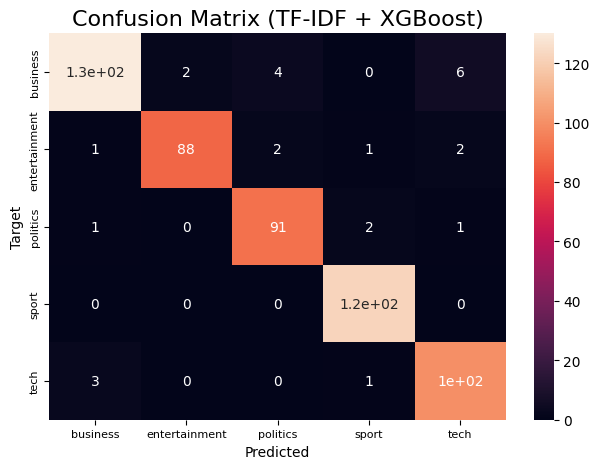

In [29]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,xgb_test_preds,labels=xgb.classes_)

ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (TF-IDF + XGBoost)',fontsize=16)
ax.xaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.yaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

## 4.3 Classification with a RandomForest

In [30]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train3,y_train)

# Use the model to predict on train data
forest_train_preds = forest.predict(X_train3)

forest_train_results = get_test_scores('RendomForest (train)',forest_train_preds,y_train)
forest_train_results

,model,precision,recall,F1,accuracy
0,RendomForest (train),1.0,1.0,1.0,1.0


In [31]:
# Use the model to predict on test data
forest_test_preds = forest.predict(X_test3)

forest_test_results = get_test_scores('RendomForest (test)',forest_test_preds,y_test)
forest_test_results

,model,precision,recall,F1,accuracy
0,RendomForest (test),0.957177,0.949795,0.952801,0.953321


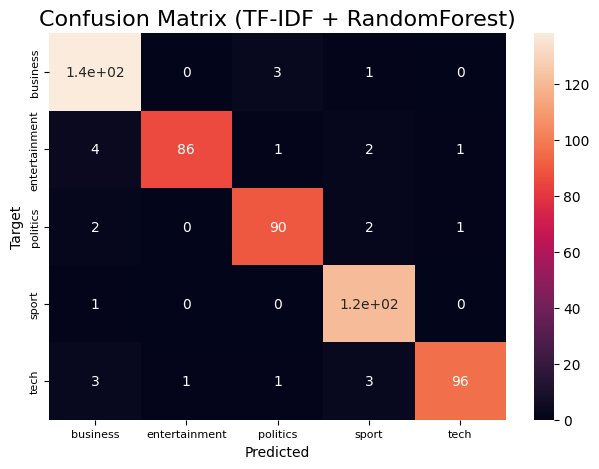

In [32]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,forest_test_preds,labels=forest.classes_)

ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (TF-IDF + RandomForest)',fontsize=16)
ax.xaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.yaxis.set_ticklabels(['business','entertainment','politics','sport','tech'],fontsize=8) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

<a id="5"></a>
# 5. Classification with CNNs and Embeddings

## 5.1 First Model

In [33]:
df2 = df.copy()
df2['targets'] = df2['labels'].astype("category").cat.codes

df2.head(2)

,text,labels,targets
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.",business,0
1,"Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""\n\nWorries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent comment

I am getting the number of target classes.

In [34]:
# Number of target classes
K = df2['targets'].max() + 1
K

5

**Train-test split and Tokenization**

I am performing the train-test split ...

In [35]:
df_train0,df_test = train_test_split(df2,test_size=0.2)

... and then train-validation split.

In [36]:
df_train,df_valid = train_test_split(df_train0,test_size=0.2)

I am manipulating the text to remove newline characters, remove punctuation, and so on.

In [37]:
df_train['text'] = text_manipulation(df_train['text'])
df_valid['text'] = text_manipulation(df_valid['text'])
df_test['text']  = text_manipulation(df_test['text'])

I am tokenizing the text ...

In [38]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)

tokenizer.fit_on_texts(df_train['text'])

sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_valid = tokenizer.texts_to_sequences(df_valid['text'])
sequences_test  = tokenizer.texts_to_sequences(df_test['text'])

... and then I am mapping the words to indices so that I can later pass the indices (i.e. integer numbers) into the network.

In [39]:
# Get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 28223 unique tokens.


I am padding the train and test sequences (sequences_train and sequences_test) in order to get a N x T matrix.

Padding must be done because every sentence in the text has not the same number of words. I can also define maximum number of words for each sentence, if a sentence is longer then I can drop some words.

In [40]:
# Pad sequences to get a N x T matrix
data_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train)
print('Shape of data train tensor:',data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1424, 3489)


In [41]:
data_valid = tf.keras.preprocessing.sequence.pad_sequences(sequences_valid,maxlen=T)
print('Shape of data validation tensor:',data_valid.shape)

Shape of data validation tensor: (356, 3489)


In [42]:
data_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test,maxlen=T)
print('Shape of data test tensor:',data_test.shape)

Shape of data test tensor: (445, 3489)


I am building a 1D CNN model. It has:

* An Input layer
* An embedding layer
* A Conv1D layer with 32 neurons
* A MaxPooling1D layer
* A final Dense layer for the output

In [43]:
# Create the model

# We get to choose embedding dimensionality
D = 50

i = tf.keras.layers.Input(shape=(T,))
x = tf.keras.layers.Embedding(V+1,D)(i)
x = tf.keras.layers.Conv1D(32,3,activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(K)(x)

model1 = tf.keras.models.Model(i,x)

After building the model, I am compiling and fitting it.

In [44]:
# Compile and fit
model1.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

print('Training model...')
history1 = model1.fit(
  data_train,df_train['targets'],
  epochs=25,
  validation_data=(data_valid,df_valid['targets'])
)

Training model...
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2867 - loss: 1.5893 - val_accuracy: 0.5927 - val_loss: 1.4726
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6856 - loss: 1.3612 - val_accuracy: 0.7556 - val_loss: 1.1102
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8068 - loss: 0.9163 - val_accuracy: 0.8624 - val_loss: 0.6522
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8838 - loss: 0.5169 - val_accuracy: 0.9045 - val_loss: 0.4313
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9128 - loss: 0.3402 - val_accuracy: 0.9298 - val_loss: 0.3206
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9510 - loss: 0.2353 - val_accuracy: 0.9382 - val_loss: 0.2589
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9709 - loss: 0.1583 - val_accuracy: 0.9466 - val_loss: 0.2237
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9824 - loss: 0.1100 - val_ac

One can notice that the model is clearly overfitting. So, let's print its loss and validation accuracy to confirm this statement.

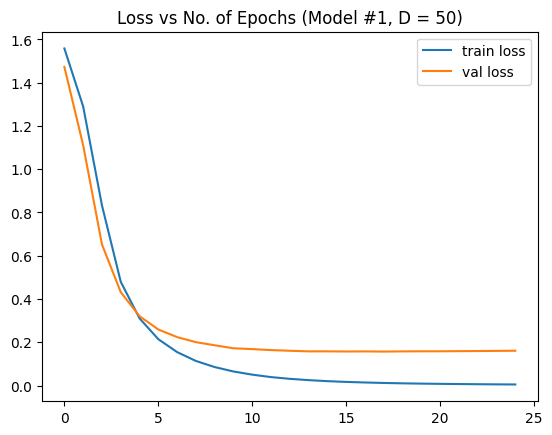

In [45]:
# Plot loss per iteration
plt.plot(history1.history['loss'],label='train loss')
plt.plot(history1.history['val_loss'],label='val loss')
plt.title('Loss vs No. of Epochs (Model #1, D = 50)')
plt.legend();

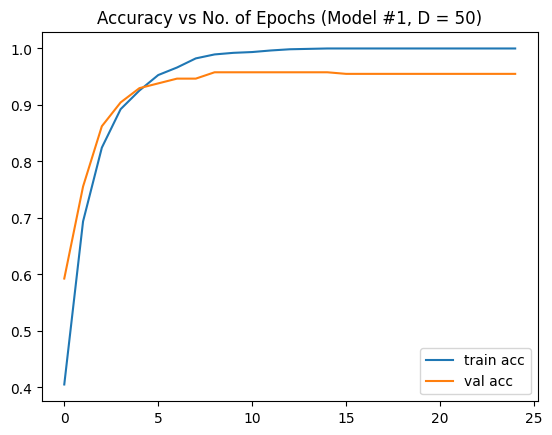

In [46]:
# Plot accuracy per iteration
plt.plot(history1.history['accuracy'],label='train acc')
plt.plot(history1.history['val_accuracy'],label='val acc')
plt.title('Accuracy vs No. of Epochs (Model #1, D = 50)')
plt.legend();

I am printing a summary of the model, including the layers and the model parameters.

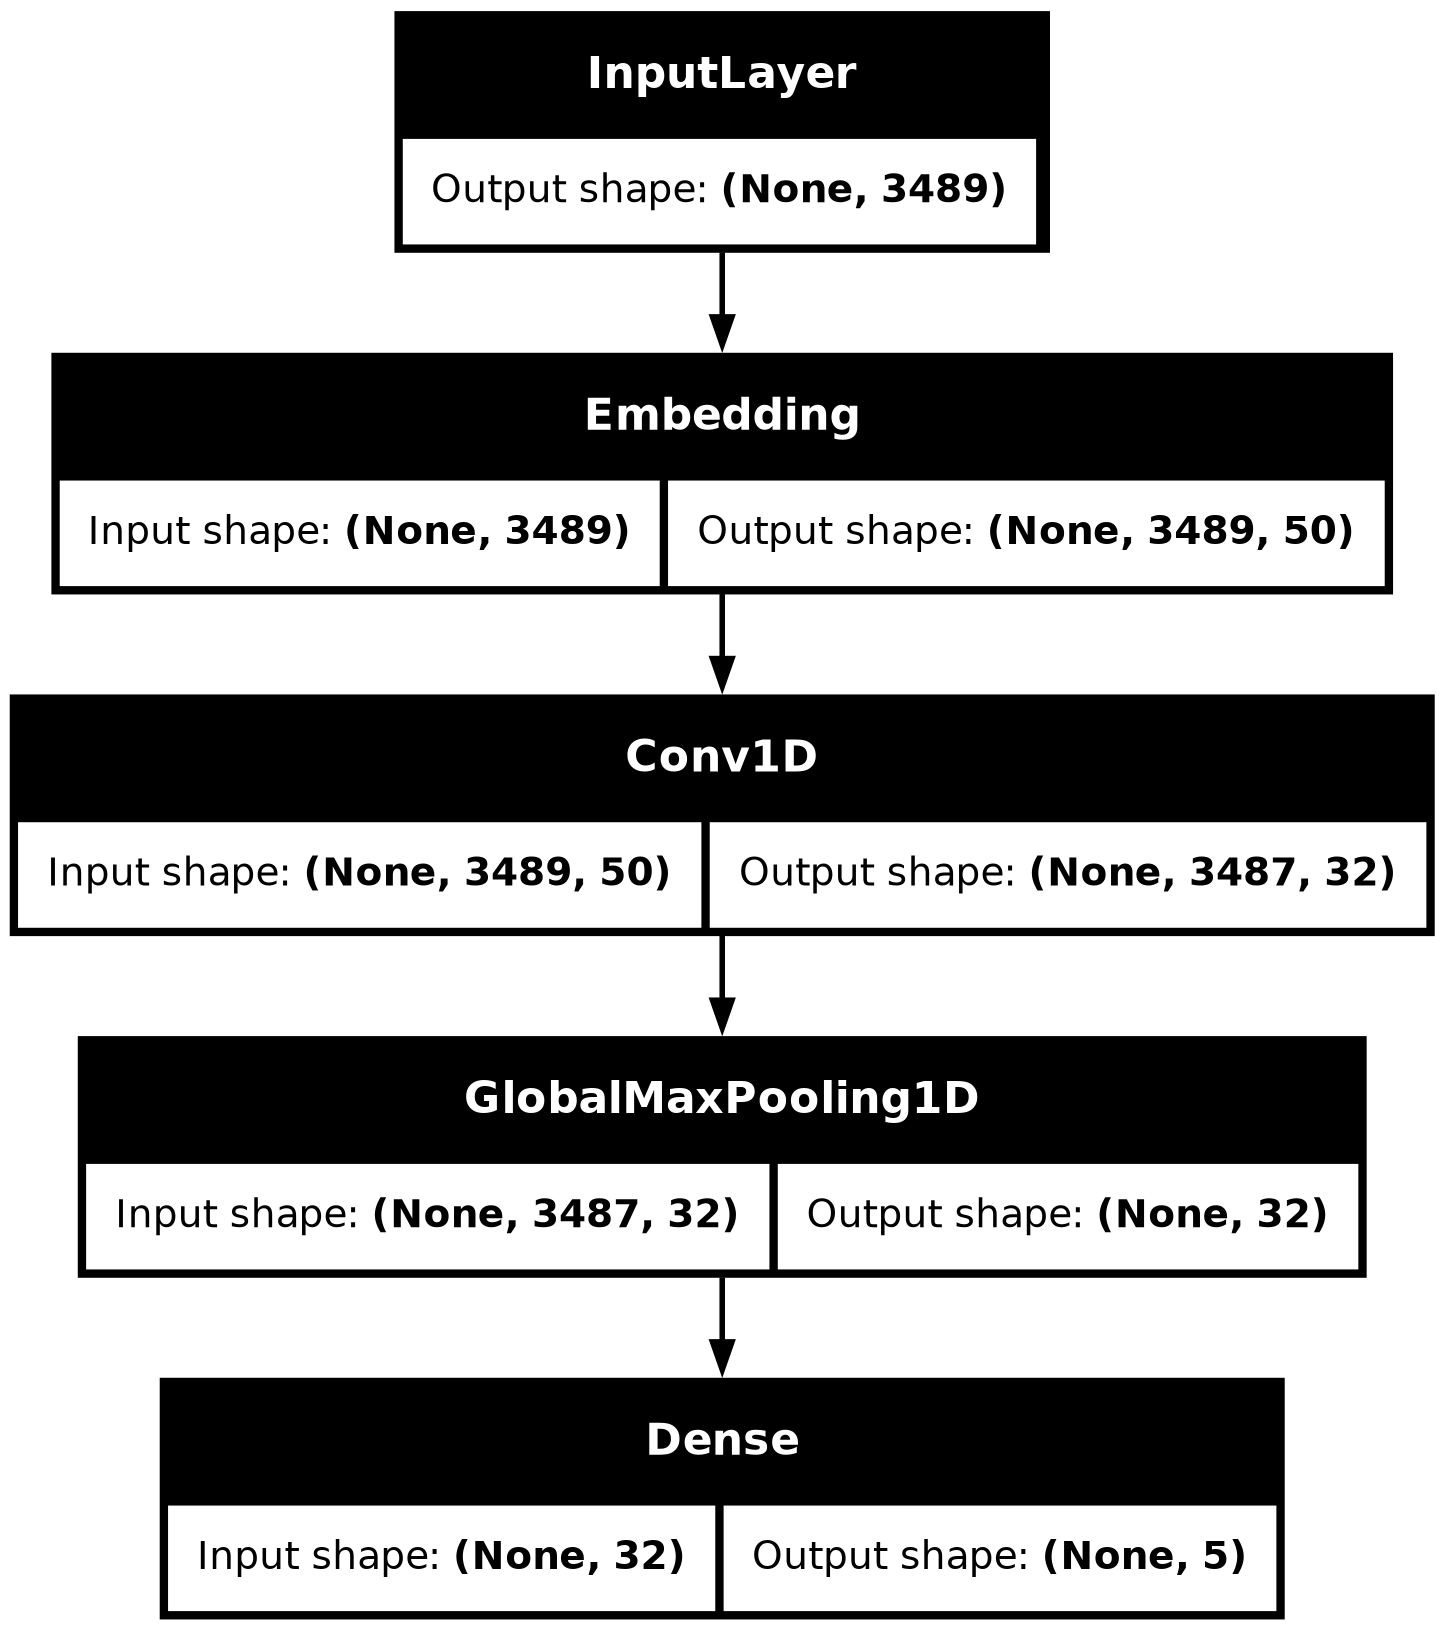

In [47]:
tf.keras.utils.plot_model(model1,show_shapes=True,to_file='model.png')

Finally, I am calculating the model scores on the test data.

In [48]:
score1 = model1.evaluate(data_test,df_test['targets'],verbose=0)
print('Test Loss: {:.4f}'.format(score1[0]))
print('Test Accuracy: {:.4f}'.format(score1[1]))

Test Loss: 0.0915
Test Accuracy: 0.9596


## 5.2 Second Model

I am building a second model, with the goal of improving the accuracy results and prevent overfitting. To do so, I am:
* defining two callbacks. The first callback is introduced to reduce the learning rate throughout the fitting process.
The second callback is a checkpoint callback. It is used to save the model parameters corresponding to the partial result with the highest (validation) accuracy in the fitting process.
* substituting the GlobalMaxPooling1D layer of model #1 with GlobalAveragePooling1D.

In [49]:
# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

# Defining the learning rate reduction routine
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

In [50]:
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

In [51]:
# Create the model

# We get to choose embedding dimensionality
D = 50

i = tf.keras.layers.Input(shape=(T,))
x = tf.keras.layers.Embedding(V+1,D)(i)
x = tf.keras.layers.Conv1D(32,3,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.4)(x) 
x = tf.keras.layers.Dense(K,activation='softmax')(x)

model2 = tf.keras.models.Model(i, x)

In [52]:
# Compile and fit
model2.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

print('Training model...')
history2 = model2.fit(
  data_train,df_train['targets'],
  epochs=25,
  validation_data=(data_valid,df_valid['targets']),
  callbacks=[learning_rate_reduction,checkpoint_callback]  
)

Training model...
Epoch 1/25
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2295 - loss: 1.6176
Epoch 1: val_accuracy improved from -inf to 0.22472, saving model to results.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2295 - loss: 1.6174 - val_accuracy: 0.2247 - val_loss: 1.5978 - learning_rate: 0.0010
Epoch 2/25
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2878 - loss: 1.5946
Epoch 2: val_accuracy improved from 0.22472 to 0.25562, saving model to results.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2870 - loss: 1.5947 - val_accuracy: 0.2556 - val_loss: 1.5916 - learning_rate: 0.0010
Epoch 3/25
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2651 - loss: 1.5824
Epoch 3: val_accuracy improved from 0.25562 to 0.35955, saving model to results.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2661 - loss: 1.5822 - val_accuracy: 0.3596 - val_loss: 1.5654 - learning_rate: 0.0010
Epoch 4/25
44/45 ━━━━━━━━━━━━━━━━━━━━

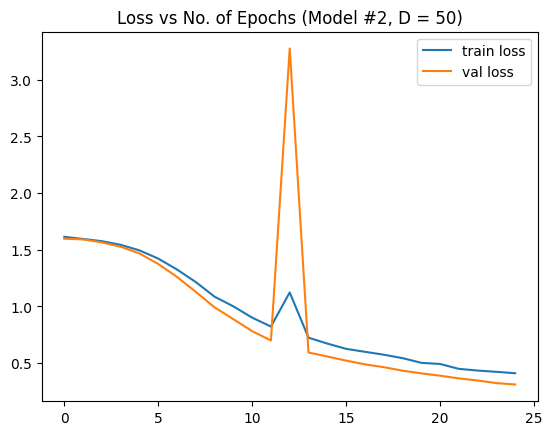

In [53]:
# Plot loss per iteration
plt.plot(history2.history['loss'],label='train loss')
plt.plot(history2.history['val_loss'],label='val loss')
plt.title('Loss vs No. of Epochs (Model #2, D = 50)')
plt.legend();

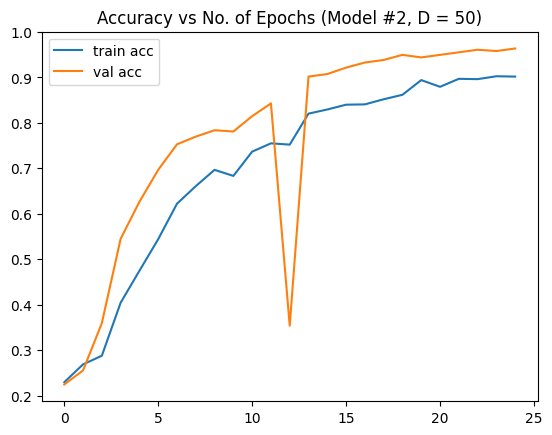

In [54]:
# Plot accuracy per iteration
plt.plot(history2.history['accuracy'],label='train acc')
plt.plot(history2.history['val_accuracy'],label='val acc')
plt.title('Accuracy vs No. of Epochs (Model #2, D = 50)')
plt.legend();

It seems that now the largest problems with overfitting are solved.

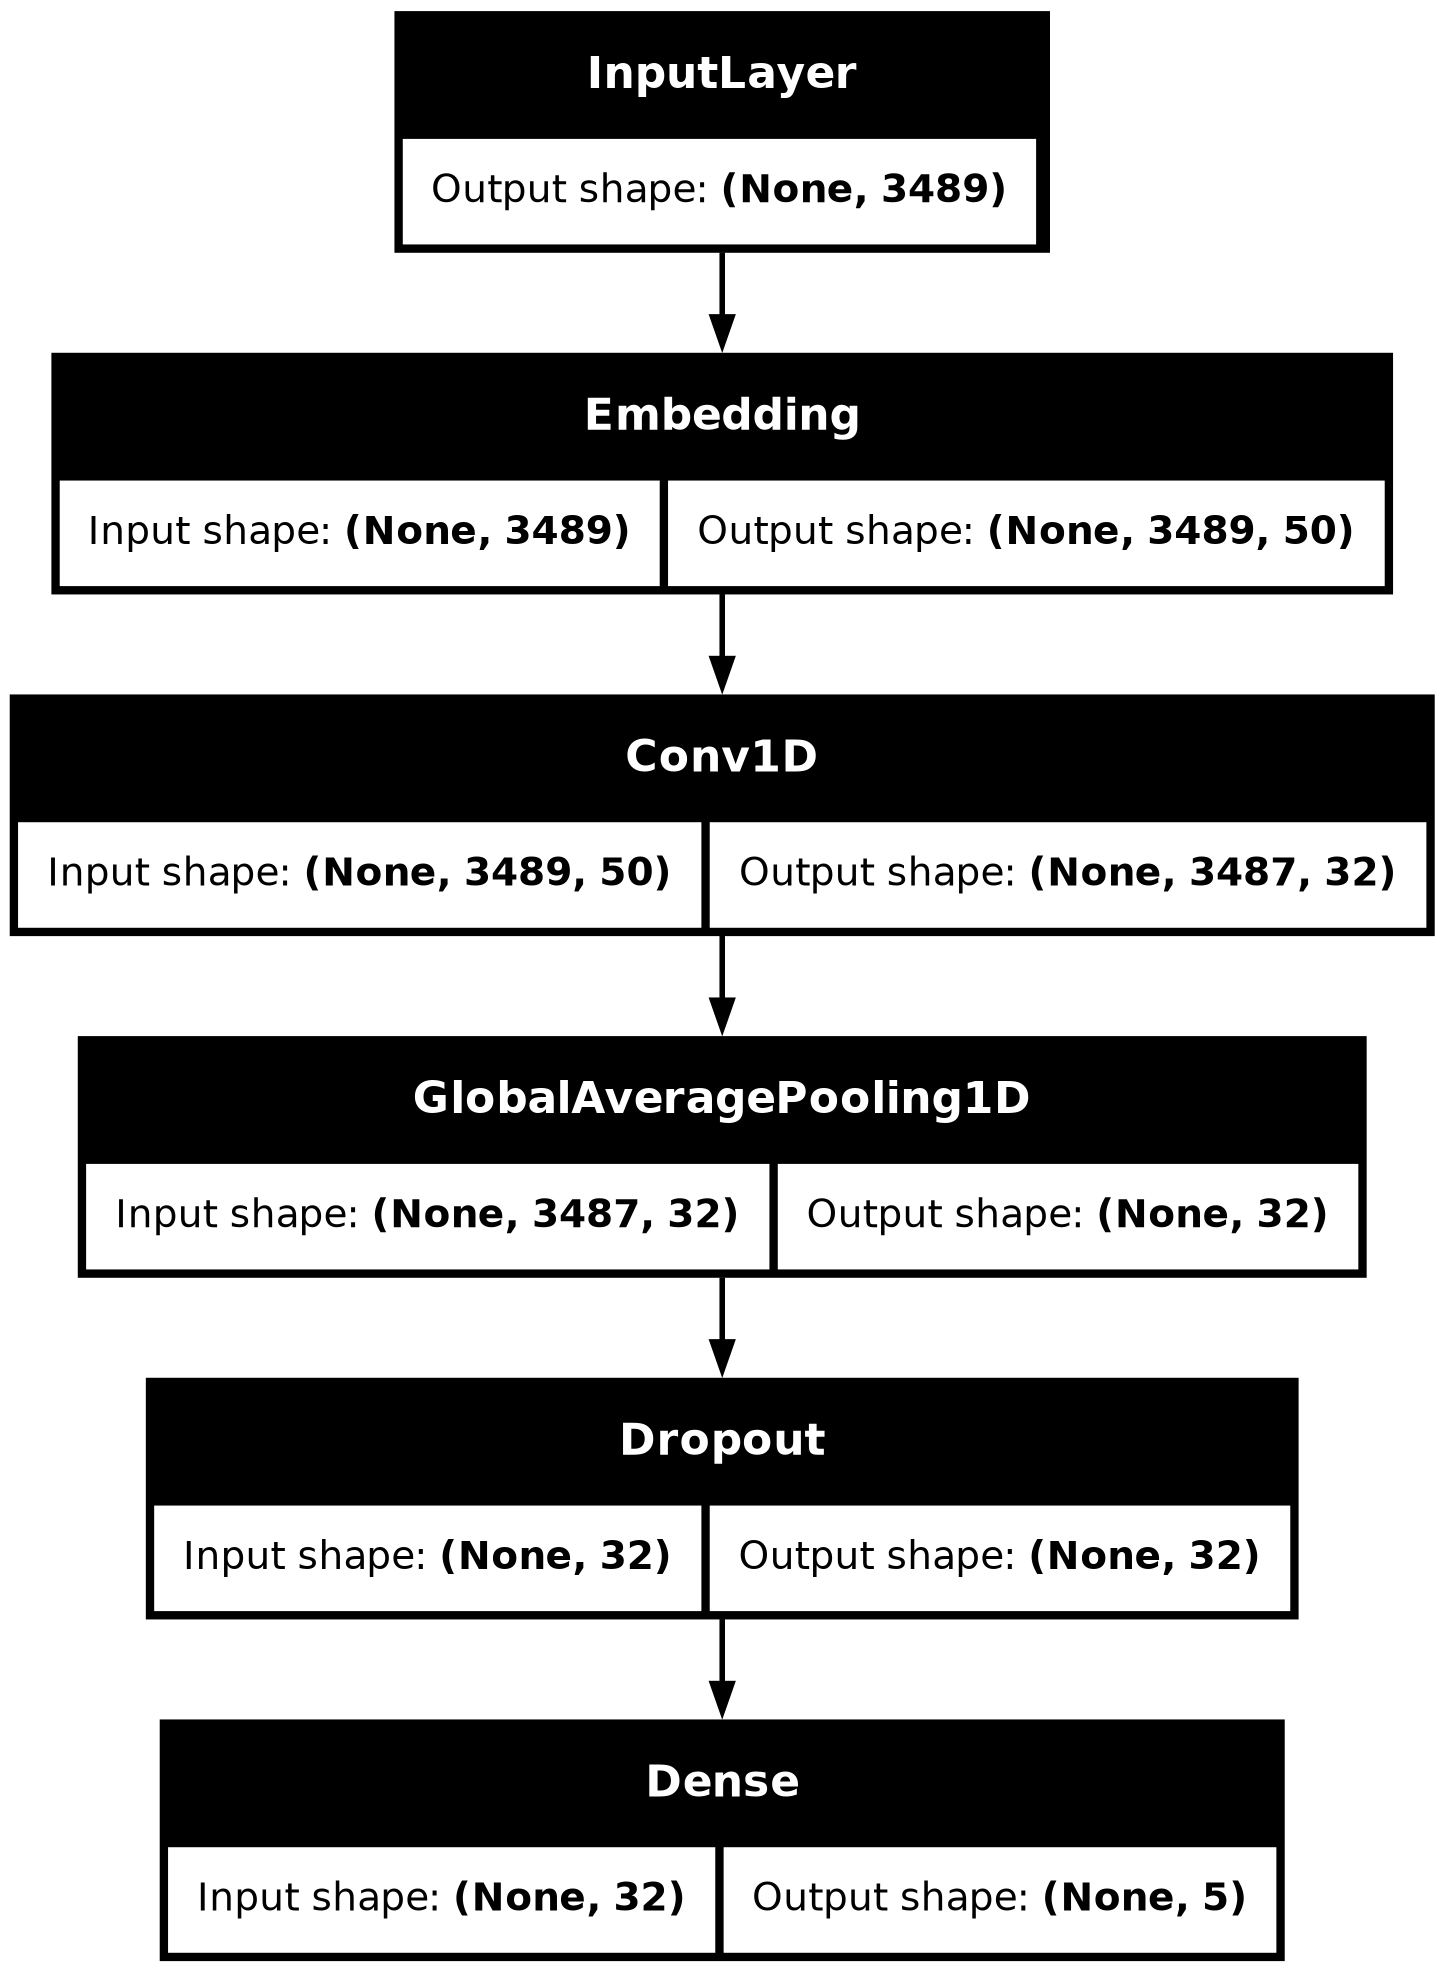

In [55]:
tf.keras.utils.plot_model(model2,show_shapes=True,to_file='model.png')

Below, I am first calculating model #2 accuracy on the test data and also obtaining the top score thanks to the saved model parameters.

In [56]:
score2 = model2.evaluate(data_test,df_test['targets'],verbose=0)
print('Test Loss: {:.4f}'.format(score2[0]))
print('Test Accuracy: {:.4f}'.format(score2[1]))

Test Loss: 0.2858
Test Accuracy: 0.9551


In [57]:
model2.load_weights(checkpoint_path)
loss,acc = model2.evaluate(data_test,df_test['targets'],verbose=0)

print('Restored model')
print('Test Loss: {:.4f}'.format(loss))
print('Test Accuracy: {:.4f}'.format(acc))

Restored model
Test Loss: 0.2858
Test Accuracy: 0.9551


# Useful Resources

* *Machine Learning: Natural Language Processing in Python (V2)*, Lazy Programmer Inc., course on Udemy.
* [*BBC News: Text Complexity and Summarization*](https://www.kaggle.com/code/jacopoferretti/bbc-news-text-complexity-text-summarization), Jacopo Ferretti, notebook on Kaggle.
* [*Digit Recognizer Competition with CNNs*](https://www.kaggle.com/code/jacopoferretti/digit-recognizer-competition-with-cnns), Jacopo Ferretti, notebook on Kaggle.
* [*Twitter Airline Sentiment (CountVectorizer & RNNs)*](https://www.kaggle.com/code/jacopoferretti/twitter-airline-sentiment-countvectorizer-rnns), Jacopo Ferretti, notebook on Kaggle.
* [*Fake News Detection (Transformers vs Naive Bayes)*](https://www.kaggle.com/code/jacopoferretti/fake-news-detection-transformers-vs-naive-bayes), Jacopo Ferretti, notebook on Kaggle.